In [315]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [366]:
import seaborn as sb
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import string
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# Check the data

In [317]:
#twdata=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#testdata=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
twdata=pd.read_csv('train.csv')
testdata=pd.read_csv('test.csv')

In [318]:
twdata.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [319]:
testdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [320]:
# check random sample to get some more understanding on the keyword & location
twdata.sample(n=5)

,id,keyword,location,text,target
5549,7915,rainstorm,"Coventry, Rhode Island",Going to the beach with Jim Alves means a guaranteed rainstorm. #lucky http://t.co/fejs0Bu0sq,0
3094,4441,electrocute,"Houston, TX",@FoxNews He still has his beard - has he been visited by any1 while in prison? If he keeps that hideous beard electrocute him! \n#UglyPeople,1
5149,7343,nuclear%20reactor,Virginia,HamptonRoadsFor.me US Navy Sidelines 3 Newest Subs - http://t.co/9QNQ45Zduw http://t.co/dhyLJllRHL,0
279,407,apocalypse,NaN,She's kinda hot played on the radio today. What's next? Disease to all? The apocalypse has started everyone. Be careful.,0
7143,10236,volcano,Santiago de Cmpostela Galicia,I added a video to a @YouTube playlist http://t.co/y2Mt6v13E8 Doc: Volcanoes and Earthquakes - Inside the Volcano,1


In [321]:
twdata.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [322]:
print('training data shape {}, test data shape {}'.format(twdata.shape,testdata.shape))

training data shape (7613, 5), test data shape (3263, 4)


# EDA

**'location' does not contain valid data and many places they are missing. So will drop this feature.**

Analyze the "keyword" feature

In [323]:
def plot_feature_col(data, col, comment):
    keyword_dist=data[col].value_counts()

    fig = plt.figure(figsize=(8, 3), dpi=100) # figsize-width,height

    keyword_dist[:40].plot.bar()

    plt.title(comment)
    plt.legend([col+' count'])
    plt.show()
    
    return keyword_dist

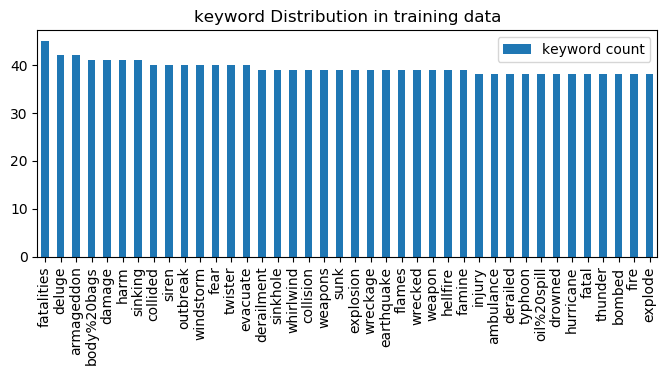

In [324]:
keyword_dist_training = plot_feature_col(twdata, 'keyword', 'keyword Distribution in training data')

In [325]:
keyword_dist_training[:100]

fatalities             45
deluge                 42
armageddon             42
body%20bags            41
damage                 41
                       ..
hijacker               35
airplane%20accident    35
screams                35
rescuers               35
inundated              35
Name: keyword, Length: 100, dtype: int64

In [326]:
pd.options.display.max_colwidth = 200  # set a value as required for better visualization

twdata.sample(n=10)

,id,keyword,location,text,target
2721,3907,devastated,NaN,Obama declares disaster for typhoon-devastated Saipan #Worldnews http://t.co/9NYXjndoRA,1
5029,7171,mudslide,NaN,RT RabidMonkeys1: Ah the unique mudslide cake ??#GBBO http://t.co/ZT5OFbiwtD,0
6515,9317,survive,Kansas,Escaping her captors was the 1st step. Now she must survive a deadly storm &amp; a wild-looking recluse.\nBETRAYED\nhttp://t.co/0Q040STkCV\n#books,1
4314,6126,hellfire,Silvermoon or Ironforge,Fel Lord Zakuun is about to DIE ! #Hellfire #WOD http://t.co/x1oNV3d5uX,1
3648,5197,fatalities,"Jogja, Indonesia Slowly Asia",Mortal Kombat X is an excellent fatalities and the most fun IÛªve ever had with a mortal kombat SEGA's version http://t.co/fLO8fgy35A,0
1581,2282,cliff%20fall,livin life in the 610,I accidentally killed an 87 day snap streak and now I wanna accidentally fall off a cliff ????????????????????,1
3808,5410,fire%20truck,Aracaju - Sergipe,#NJTurnpike å_ #NJTurnpike Reopens Hours After Truck Fire In? http://t.co/oABJZtbVyZ http://t.co/GPBXRrDc07,1
268,389,annihilation,NaN,THANKS!!!!! @COUNT DANTE. :) DO JOIN US BY FOLLOWING THE @ANNIHILATION ZONE. JOHNNY.,0
1691,2441,collide,"Houston, Texas",When Houston and NYC collide. ?? @pageparkescorp @chloeunguyen @laurensicle @charstevens97 @tiara_marei #gemma #boweÛ_ http://t.co/9wowPs78VD,1
1122,1618,bombed,NaN,Me trying to pass lax with my family ends up by me having to run after the ball after it gets bombed over my head,0


**Check the test data keyword distribution**

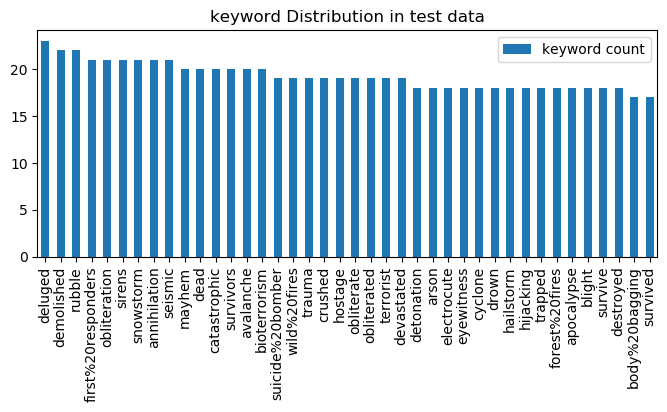

In [327]:
# check the keyword distribution using plot
keyword_dist_test = plot_feature_col(testdata, 'keyword', 'keyword Distribution in test data')

In [328]:
keyword_dist_test[:100]

deluged                23
demolished             22
rubble                 22
first%20responders     21
obliteration           21
                       ..
casualties             15
airplane%20accident    15
tornado                15
hazardous              15
rescuers               15
Name: keyword, Length: 100, dtype: int64

**From the above analysis its observed that most of the times keyword's are allready present in the text and some time not.**
**Also many keyword's are common in training & test data.**
**Will combine the keyword and text features for further analysis**

In [329]:
# for keyword fill the NaN values as NAN, will remove the same later
twdata['keyword'].fillna('NAN', inplace=True)
testdata['keyword'].fillna('NAN', inplace=True)

In [330]:
twdata['text']=twdata['text'] + " " + twdata['keyword']
testdata['text']=testdata['text'] + " " + testdata['keyword']

In [331]:
twdata.sample(5)

,id,keyword,location,text,target
124,178,aftershock,United States,&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z\n@esquireattire aftershock,0
132,191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night. aftershock,0
2196,3145,debris,Hong Kong,Plane debris is from missing MH370 http://t.co/kxy56FR8vM debris,1
1933,2780,curfew,NaN,@ScotRail i be seen them turn a blind eye to a bloke drinking and smoking on during the curfew time cos'its not worth the hassle' curfew,1
2881,4141,drought,miami,@_gaabyx we got purple activist I thought it was a drought drought,1


In [332]:
testdata.sample(5)

,id,keyword,location,text
374,1197,blizzard,New York,GUNNAR Optiks -Heroes of the Storm Siege Gaming Glasses - Onyx/Fire wow blizzard - Full reÛ_ http://t.co/YEUQp0VKwU http://t.co/OuGM0yxQMo blizzard
1777,6008,hazardous,NaN,#diablo #dsp Olap #world pres: http://t.co/LFEtNRXyWt How To Recognize A Hazardous Waste And The Multidimensio http://t.co/PvNvqaXsA7 hazardous
2530,8442,screamed,NaN,I screamed when @g_montani @jessemontani were running to John for 1st place! I'm so happy I love you guys ?? #AmazingRaceCanada screamed
979,3238,deluged,NaN,Businesses are deluged with ivoices. Make yours stand out with colour or shape and it's likely to ris; to the top of the pay' pile. deluged
1504,5011,eyewitness,Washington DC,Hero of capitalism: Sprint employee promotes Sprint while Fox News interviews him as a shooting eyewitness: https://t.co/DtRPhCTmJx eyewitness


In [333]:
# drop location & keyword column
twdata.drop(columns=['location','keyword'],axis=1, inplace=True)
testdata.drop(columns=['location','keyword'],axis=1, inplace=True)

In [334]:
# verify the final tables

In [335]:
twdata.head(2)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1
1,4,Forest fire near La Ronge Sask. Canada NAN,1


In [336]:
twdata.head(2)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1
1,4,Forest fire near La Ronge Sask. Canada NAN,1


In [337]:
twdata.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [338]:
testdata.isnull().sum()

id      0
text    0
dtype: int64

**plot the 'target' to understand its distribution**

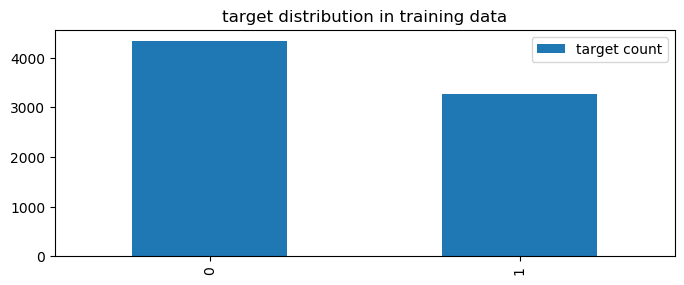

In [339]:
target_dist_training = plot_feature_col(twdata, 'target', 'target distribution in training data')

**there is no big gap between two different kind of taget types, will go with this as it is**

# Remove noise from data
Here train & test data both consists of lot of noise (stop words, delimeters, special symbols, lower case etc.) that need to be removed before we process the data further.

In [340]:
def _to_lower(datax, col):
    """ convert to lower case """
    datax['clean_text'] = datax[col].apply(lambda x: x.lower())


In [341]:
_to_lower(twdata, 'text')
_to_lower(testdata, 'text')
twdata.head(2)

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1,our deeds are the reason of this #earthquake may allah forgive us all nan
1,4,Forest fire near La Ronge Sask. Canada NAN,1,forest fire near la ronge sask. canada nan


In [342]:
# load spacy for few other cleaning
nlp = spacy.load('en_core_web_sm')

In [343]:
# tokenize 
twdata['clean_text']=twdata['clean_text'].apply(lambda x: list(nlp(x)))

In [344]:
twdata.head(2)

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all, nan]"
1,4,Forest fire near La Ronge Sask. Canada NAN,1,"[forest, fire, near, la, ronge, sask, ., canada, nan]"


In [345]:
def spacy_clean(data, col):
    # remove punctuations 
    data[col] = data[col].apply(lambda x: [t for t in x if (t.is_punct == False)])
    
    # remove stopwords
    data[col] = data[col].apply(lambda x: [t for t in x if (t.is_stop == False)])
    
    # lemmatize
    data[col] = data[col].apply(lambda x: [t.lemma_ for t in x])
    
    # join it to get back the original sentence
    data[col] = data[col].apply(lambda x: " ".join(x))

In [346]:
spacy_clean(twdata, 'clean_text')

In [347]:
# check the cleaned data
twdata.head(5)

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1,deed reason earthquake allah forgive nan
1,4,Forest fire near La Ronge Sask. Canada NAN,1,forest fire near la ronge sask canada nan
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected NAN,1,resident ask shelter place notify officer evacuation shelter place order expect nan
3,6,"13,000 people receive #wildfires evacuation orders in California NAN",1,"13,000 people receive wildfire evacuation order california nan"
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school NAN,1,get send photo ruby alaska smoke wildfire pour school nan


In [380]:
# this data still has http://, @..., so need to clean further
def clean_regex(data, col):
    # remove http://
    data[col]=data[col].apply(lambda x: re.sub(r'http\S+', '', x))
    # remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    data[col]=data[col].apply(lambda text: ''.join([x for x in text if x not in string.punctuation]))
    # remove non ascii
    data[col]=data[col].apply(lambda text: ''.join([x for x in text if ord(x) < 128]))


In [381]:
clean_regex(twdata, 'clean_text')

In [383]:
twdata.sample(5)

,Unnamed: 0,id,text,target,clean_text
6902,6902,9894,A spider has legit just run across my chest. Traumatised. For. Life. traumatised,0,spider legit run chest traumatise life traumatise
3468,3468,4961,New Explosion-proof Tempered Glass Screen Protector Film for Blackberry Z10 - Full read byÛ_ http://t.co/ModqNaLWsB http://t.co/4C58oOaVhY explosion,0,new explosion proof temper glass screen protector film blackberry z10 read by explosion
1523,1523,2203,Excited not only about the next 6 years of school and ensuing student debt but also catastrophic climate change in my lifetime \n\n:D ?? catastrophic,0,excited 6 year school ensue student debt catastrophic climate change lifetime \n\n d catastrophic
7310,7310,10462,In Europe nature is kind while in US they have tornados hurricanes wild fires earthquakes flash floods mega snow droughts. wild%20fires,1,europe nature kind tornados hurricane wild fire earthquake flash flood mega snow drought wild20fire
5376,5376,7672,Every time I feel a new pain or strain in my body I panic because I need it for my career ?? panic,0,time feel new pain strain body panic need career panic


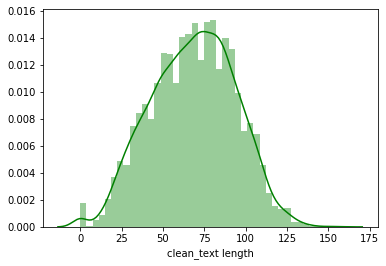

In [392]:
# check the clean text length distribution
clean_text_length=[len(x) for x in twdata['clean_text']] 
sb.distplot(clean_text_length, axlabel='clean_text length', color="g")

In [400]:
twdata.shape

(7613, 5)

In [401]:
# because of text cleaning few clean_text fields are zero length.
zl_idx=[idx for idx in range(len(clean_text_length)) if clean_text_length[idx]==0]
# drop this rows
twdata.drop(columns=['clean_text'],axis=0, inplace=True, index=zl_idx)

In [402]:
twdata.shape

(7562, 4)

In [404]:
twdata.to_csv('train_clean.csv')